In [1]:
%load_ext watermark
%watermark -a Filippo_Valle -p pandas,regex -m

Author: Filippo_Valle

pandas: 1.3.3
regex : 2021.9.30

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.13.0-28-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



https://github.com/EGA-archive/ega-download-client

`pyega3 -d fetch EGAF00000171401`

`pyega3 -d fetch EGAF00000245831`

In [2]:
import pandas as pd
import regex as re

In [3]:
df = pd.read_csv("EGAF00000171401/Illumina_HT12_normalised_mRNA_expression.xls", sep=" ")
print(df.shape)
df.head()

(14519, 1302)


,MB-0000,MB-0002,MB-0008,MB-0010,MB-0020,MB-0028,MB-0035,MB-0036,MB-0039,MB-0045,...,MB-5641,MB-5642,MB-5645,MB-5647,MB-5648,MB-5651,MB-5652,MB-5653,MB-5654,MB-5655
ENSG00000000003,8.131,7.388,8.203,6.966,8.721,8.815,8.191,6.855,7.971,7.394,...,7.072,7.054,5.740,6.263,8.177,7.357,7.957,6.938,7.489,8.427
ENSG00000000005,8.610,5.482,5.923,5.803,5.625,5.270,5.301,6.324,5.569,5.630,...,5.551,5.602,5.694,5.666,5.637,5.927,6.156,5.643,5.319,5.477
ENSG00000000419,8.927,11.189,9.757,10.059,9.598,9.778,9.097,9.314,10.523,9.429,...,8.248,8.872,9.029,8.503,8.733,8.431,8.957,9.342,9.121,8.395
ENSG00000000457,6.379,7.674,7.507,8.005,7.176,6.978,8.094,6.937,7.634,7.033,...,6.612,7.114,6.902,7.038,7.604,7.337,7.349,7.326,8.252,7.912
ENSG00000000460,6.050,6.821,6.702,7.742,6.620,6.862,6.951,6.727,6.146,7.249,...,6.717,7.010,6.333,6.342,6.729,7.711,5.927,6.166,6.880,7.875


In [4]:
df_mirna = pd.read_csv("EGAF00000245831/Agilent_ncRNA_60k_normalised_miRNA_expression.xls", sep="\t").set_index("miRNA").drop("ProbeID", axis=1)
df_mirna = df_mirna.loc[~df_mirna.index.duplicated(),:]
print(df_mirna.shape)
df_mirna.head()

(823, 1446)


,MB-2718,MB-2616,MB-2634,MB-2643,MB-2613,MB-2629,MB-2645,MB-2626,MB-2842,MB-2772,...,MB-0619,MB-0171,MB-0310,MB-0489,MB-0621,MB-0614,MB-0372,MB-0335,MB-0407,MB-0374
miRNA,,,,,,,,,,,,,,,,,,,,,
hsa-let-7b*,6.292,6.445,6.406,6.333,6.281,6.410,6.386,6.319,6.542,6.402,...,6.209,6.526,6.344,6.587,6.304,6.324,6.325,6.322,6.301,6.411
hsa-let-7d,11.813,10.380,10.028,10.624,9.235,9.818,10.675,10.522,10.199,9.609,...,10.301,9.944,9.006,9.373,10.316,9.773,9.808,8.085,10.171,10.558
hsa-let-7d*,6.315,6.334,6.253,6.305,6.299,6.299,6.247,6.305,6.293,6.237,...,6.368,6.291,6.249,6.297,6.310,6.303,6.291,6.229,6.297,6.404
hsa-let-7f-1*,6.333,6.288,6.375,6.300,6.563,6.280,6.420,6.518,6.498,6.669,...,6.867,6.248,6.605,6.584,6.636,6.318,6.521,6.389,6.352,6.434
hsa-let-7i*,6.187,6.265,6.310,6.233,6.282,6.304,6.233,6.328,6.220,6.283,...,6.266,6.171,6.229,6.358,6.323,6.238,6.276,6.182,6.419,6.301


In [5]:
df = df.reindex(columns=df.columns[df.columns.isin(df_mirna.columns)])
df_mirna = df_mirna.reindex(columns=df.columns)

In [6]:
df_tcga = pd.read_csv("../mainTable_hv.csv",index_col=0)

In [7]:
df = df.reindex(index=df.index[df.index.isin(df_tcga.index)])

In [8]:
#df_tcga = pd.read_csv("../mainTable_mirna.csv",index_col=0)
#df_mirna.reindex(index=df_mirna.index[df_mirna.index.isin(df_tcga.index.drop_duplicates())])

In [9]:
df_all = pd.concat([df,df_mirna], axis=0)

## hSBM

In [10]:
import sys
sys.path.append("../../hSBM_Topicmodel/")
from sbmtm import sbmtm

In [11]:
hsbm = sbmtm()
hsbm.make_graph_from_BoW_df(df.fillna(0))

In [12]:
hsbm.g

<Graph object, undirected, with 3323 vertices and 2631341 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fc951348d60>

In [13]:
hsbm.save_graph("graph_metabric_hsbm.xml.gz")

## triSBM

In [14]:
from trisbm import trisbm

In [15]:
trisbm_model = trisbm()
trisbm_model.make_graph(df_all.fillna(0), lambda gene: 1 if "ENSG" in gene else 2)

In [16]:
trisbm_model.save_graph("graph_metabric_trisbm.xml.gz")

In [17]:
import numpy as np
np.isin(hsbm.words, trisbm_model.words).sum()

2021

In [18]:
df_files = pd.read_excel("../brca/41523_2021_345_MOESM2_ESM.xlsx", skiprows=4)
def parse_metabric_sample(sample):
    if re.match("MB.[0-9]{4}", sample):
        sample=sample.replace(".","-")
    return sample
df_files["sample"]=list(map(parse_metabric_sample,df_files["sample"]))
df_files.set_index("sample", inplace=True)

In [20]:
df_files = df_files.reindex(index=df_all.columns).fillna("unknown")

In [49]:
analyses = {
    "subtypes": ["hsbm_bccs", "trisbm_bccs", "shuffle"],
}

In [22]:
labels = ['BCS subtype', 'BCCS subtype']

### subtypes

In [30]:
from topicpy.hsbmpy import get_scores, get_scores_shuffled, add_score_lines, normalise_score, get_cluster_given_l, get_clustersinfo, get_fraction_sites, plot_cluster_composition
import matplotlib.pyplot as plt

In [44]:
directory = "./"

scores = {}
scores['hsbm_bcs'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[1]]
scores['trisbm_bcs'] = get_scores(directory, labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[1]]

scores['hsbm_bccs'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[1]]
scores['trisbm_bccs'] = get_scores(directory, labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[1]]


scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[1], algorithm='topsbm')
shuffle = []
for _ in range(50):
    shuffle.append(get_scores_shuffled(directory, df_files, label=labels[1], algorithm='topsbm')["V"])
scores["shuffle"]["V"] = np.average(shuffle,0)
normalise_score(scores, base_algorithm="shuffle")

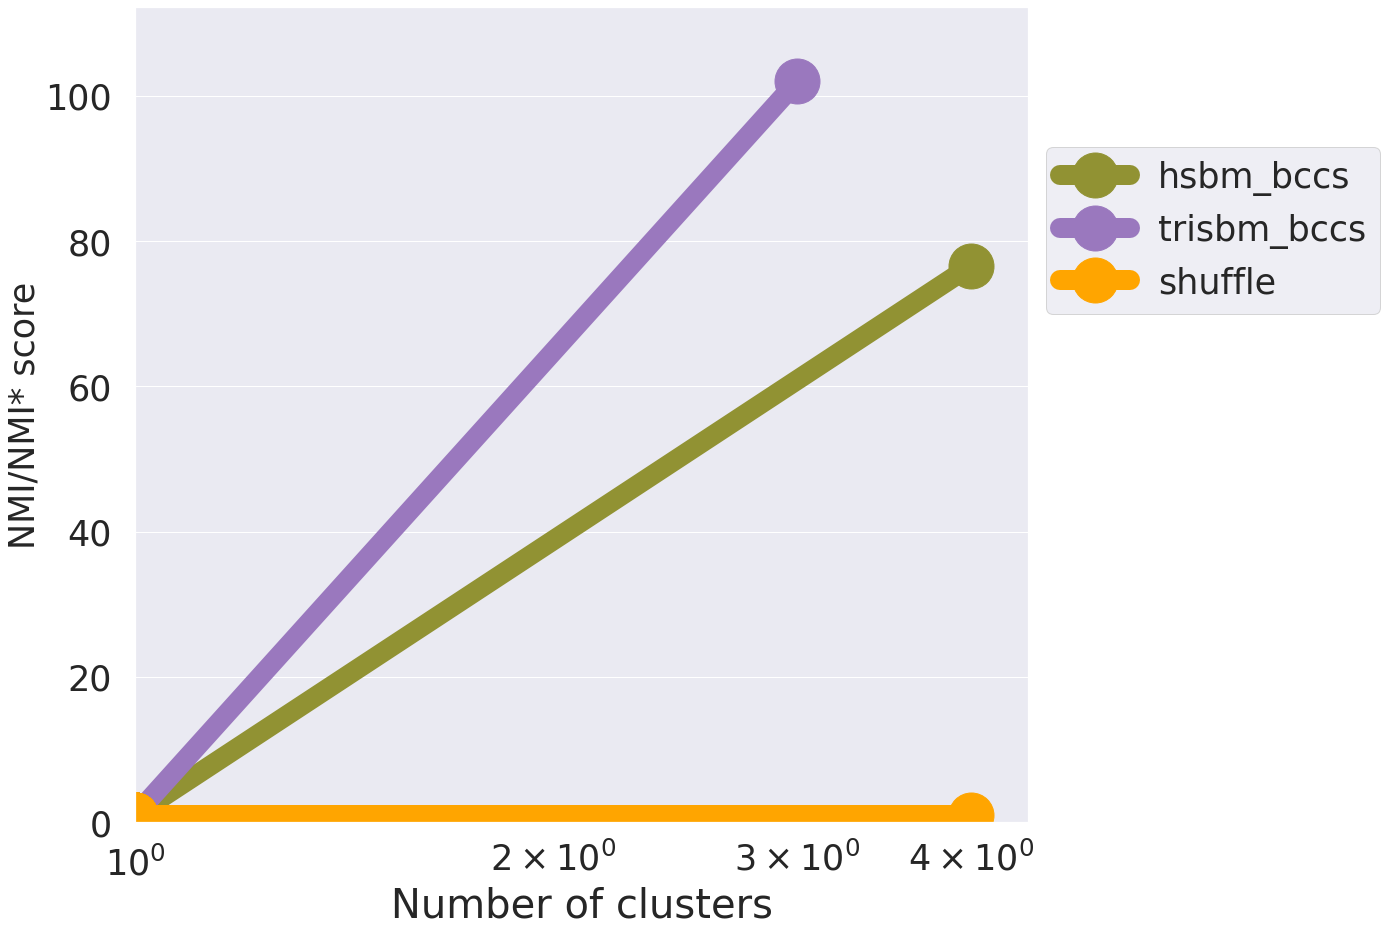

In [53]:
analysis = "subtypes"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
#ax.set_title("Tumor/Normal", fontsize=40)
ax.set_ylabel("NMI/NMI* score", fontsize=35)

plt.xlim(1,max(map(max,[score["xl"] for score in scores.values()]))*1.1)
plt.ylim(0,max(map(max,[score["norm_V"] for score in scores.values()]))*1.1)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

/opt/conda/lib/python3.8/site-packages/topicpy/hsbmpy/hsbmpy.py:234: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(1).to_dict(orient='list')


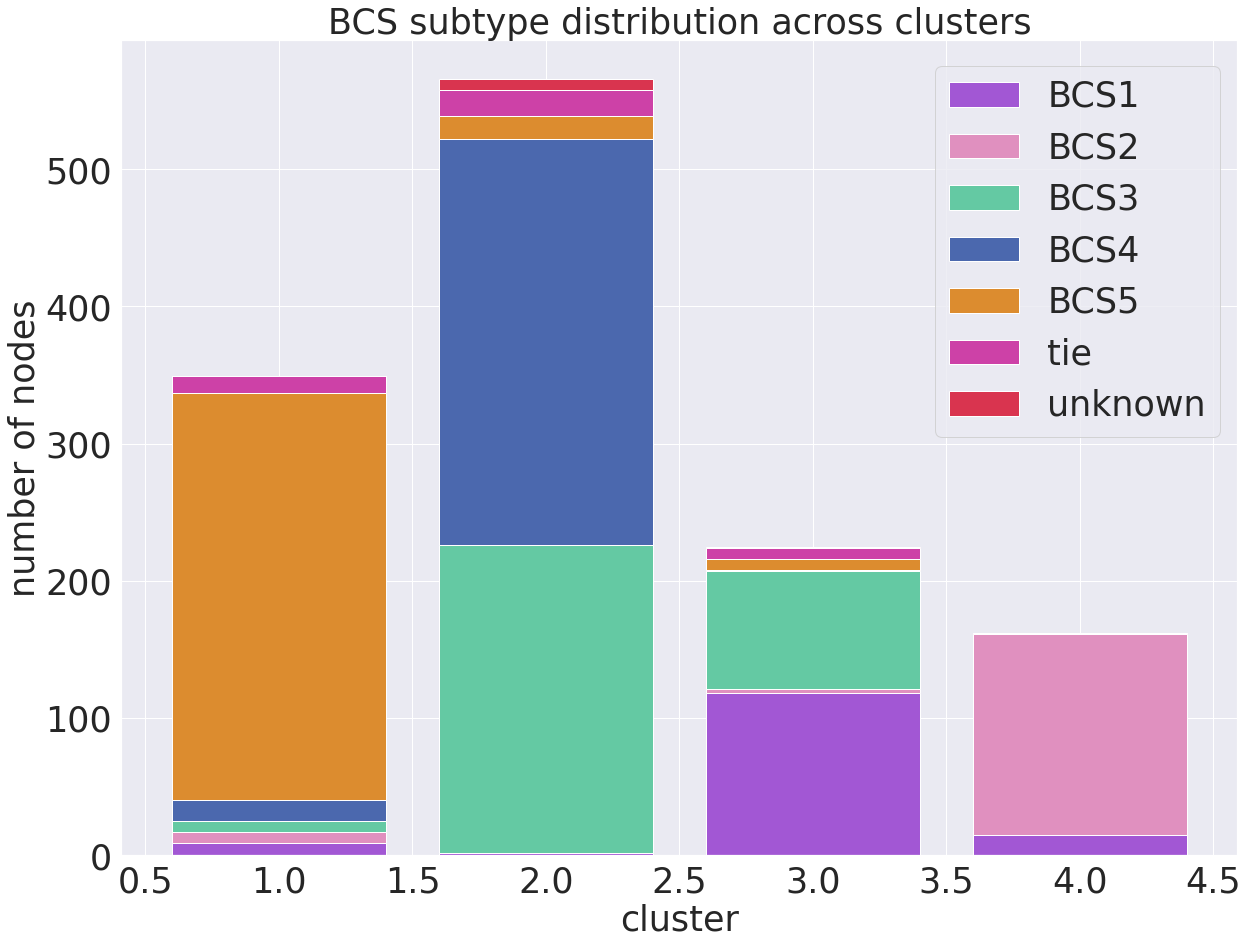

In [40]:
level = 0
algorithm = "topsbm"
cluster = get_cluster_given_l(level, ".", algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster, df_files=df_files, label=labels[0], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,".",level,label=labels[0], normalise=False,algorithm=algorithm)

/opt/conda/lib/python3.8/site-packages/topicpy/hsbmpy/hsbmpy.py:234: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(1).to_dict(orient='list')


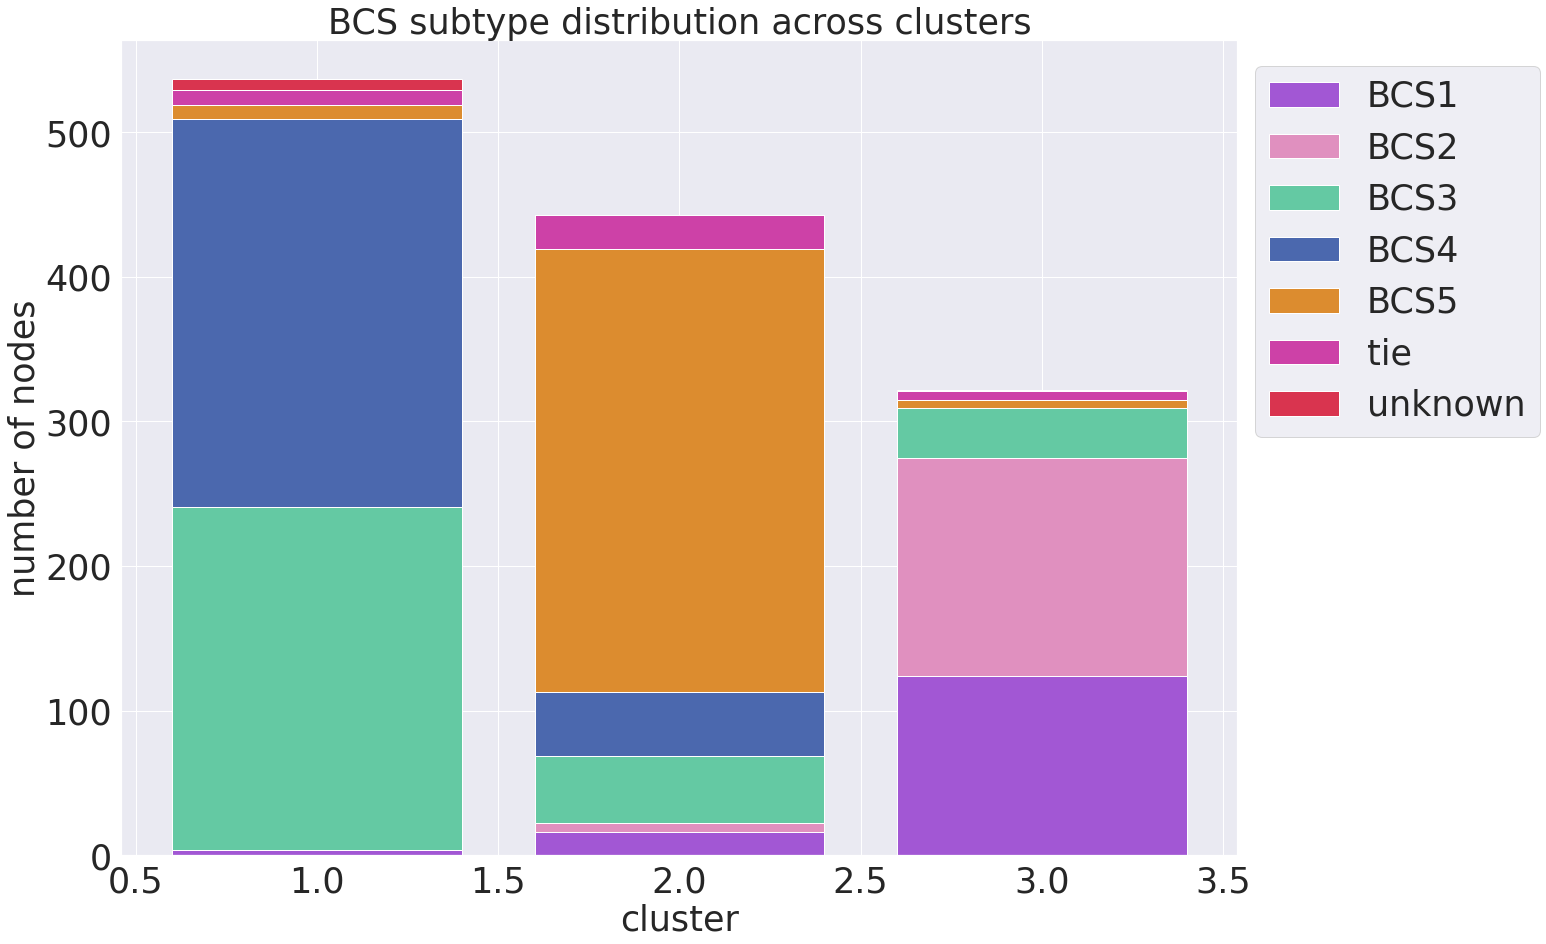

In [43]:
level = 0
algorithm = "trisbm"
cluster = get_cluster_given_l(level, ".", algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster, df_files=df_files, label=labels[0], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,".",level,label=labels[0], normalise=False,algorithm=algorithm)

/opt/conda/lib/python3.8/site-packages/topicpy/hsbmpy/hsbmpy.py:234: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(1).to_dict(orient='list')


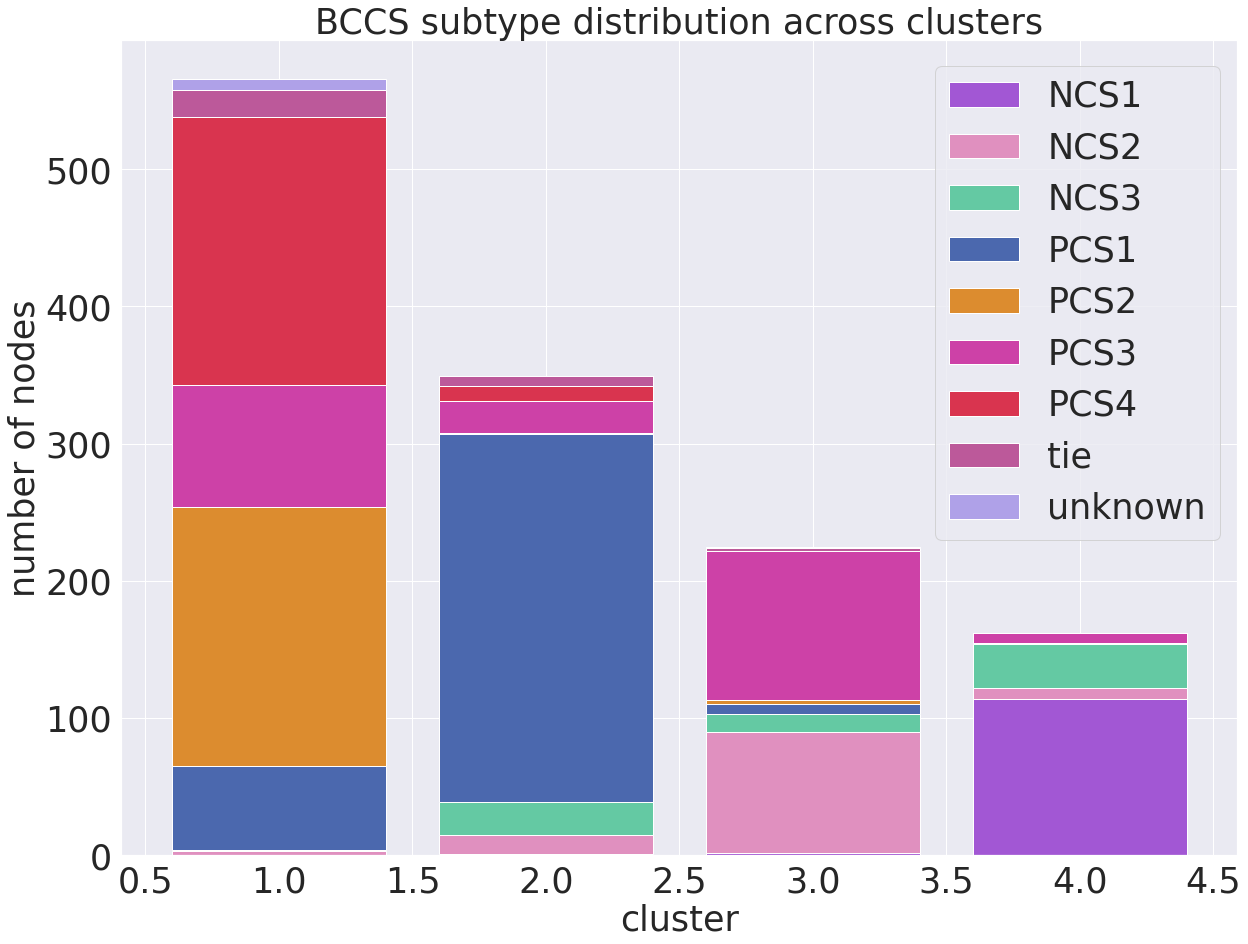

In [47]:
level = 0
algorithm = "topsbm"
cluster = get_cluster_given_l(level, ".", algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster, df_files=df_files, label=labels[1], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,".",level,label=labels[1], normalise=False,algorithm=algorithm)

/opt/conda/lib/python3.8/site-packages/topicpy/hsbmpy/hsbmpy.py:234: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(1).to_dict(orient='list')


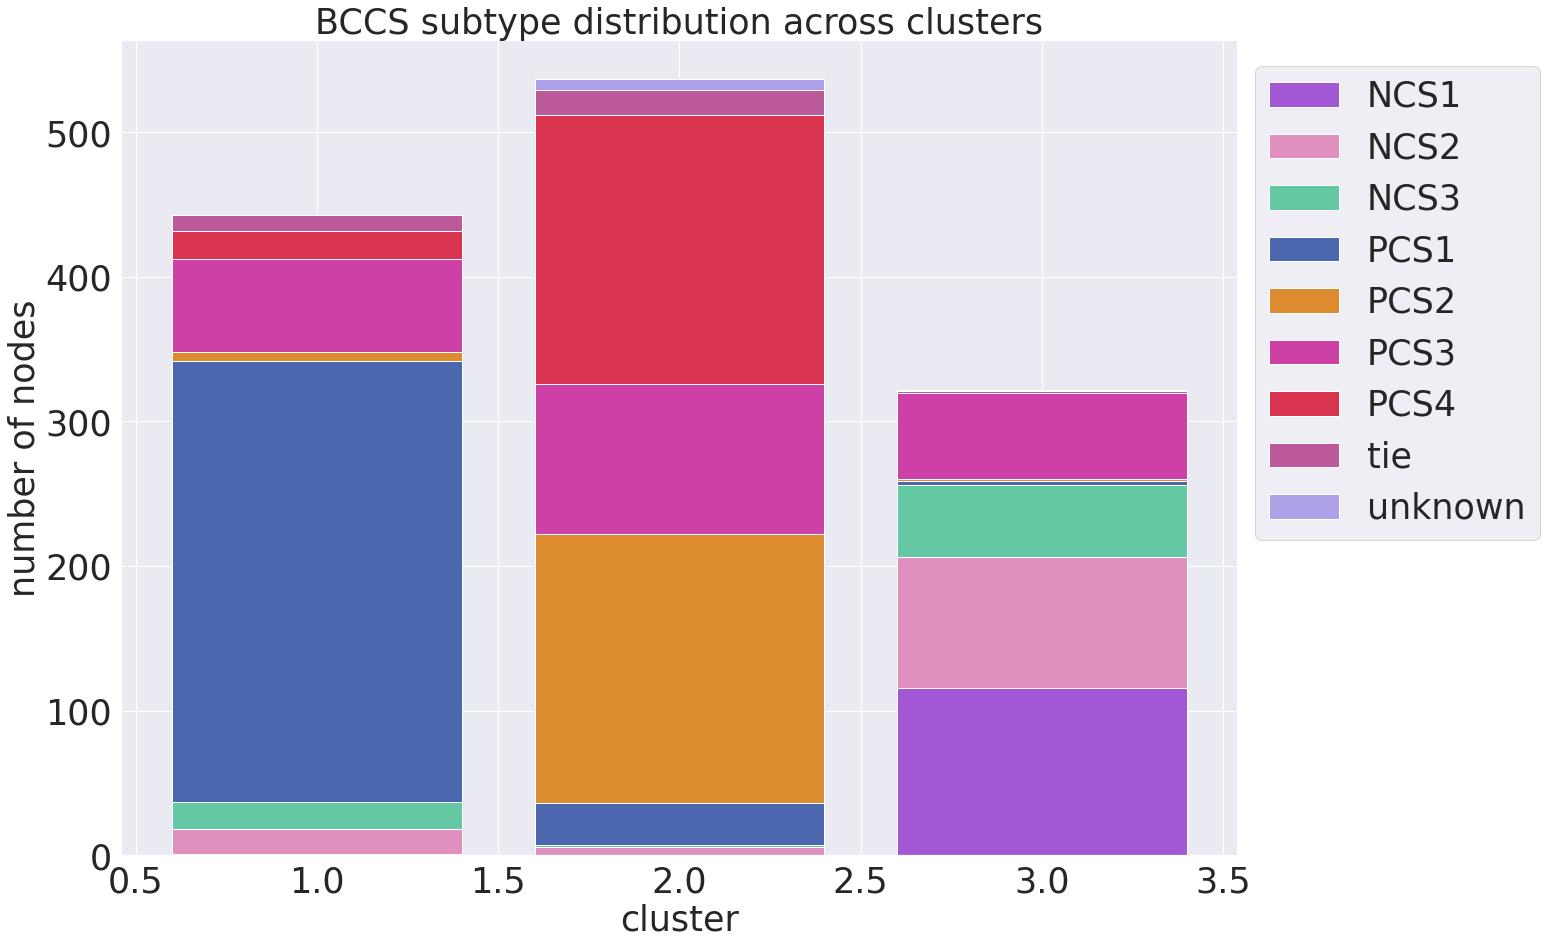

In [48]:
level = 0
algorithm = "trisbm"
cluster = get_cluster_given_l(level, ".", algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster, df_files=df_files, label=labels[1], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,".",level,label=labels[1], normalise=False,algorithm=algorithm)